In [ ]:
%matplotlib inline


# Speech Command Classification with torchaudio

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
[torchaudio](https://github.com/pytorch/audio)_ that can be installed
by following the instructions on the website.


In [ ]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pydub torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209)_, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [ ]:
!pip install rarfile

In [ ]:
import rarfile
import os

def extract_rar(rar_path, extract_to):
    # Ensure the extract directory exists
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    # Open and extract the .rar file
    with rarfile.RarFile(rar_path) as rf:
        rf.extractall(path=extract_to)

    print(f"Extracted to {extract_to}")

# Path to your .rar file and where to extract
rar_file_path = "/content/recordings_v2.rar"
extract_to_path = "/content"

# Extract the .rar file
extract_rar(rar_file_path, extract_to_path)


Extracted to /content


In [ ]:
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
import os
from torchaudio.transforms import Resample

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None, dataset_path: str = "./", target_sample_rate: int = 16000):
        super().__init__(dataset_path, download=False)
        self.target_sample_rate = target_sample_rate

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

    def __getitem__(self, n):
        # Load the waveform, sample rate, and metadata
        fileid = self._walker[n]
        waveform, sample_rate = torchaudio.load(fileid)

        # Resample if necessary
        if sample_rate != self.target_sample_rate:
            resampler = Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
            waveform = resampler(waveform)

        label = os.path.basename(os.path.dirname(fileid))
        speaker_id = fileid.split("/")[-2]  # Extract speaker ID from path
        utterance_number = int(os.path.basename(fileid).split("_")[-1].split(".")[0])

        return waveform, self.target_sample_rate, label, speaker_id, utterance_number

# Specify the path to your local dataset folder and target sample rate
local_dataset_path = "/content/recordings"
target_sample_rate = 16000

# Create training and testing split using the local folder and resampling
train_set = SubsetSC("training", dataset_path=local_dataset_path, target_sample_rate=target_sample_rate)
test_set = SubsetSC("testing", dataset_path=local_dataset_path, target_sample_rate=target_sample_rate)

# Example usage: access the first sample
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]


A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([2, 24235])
Sample rate of waveform: 16000
Label of waveform: backward


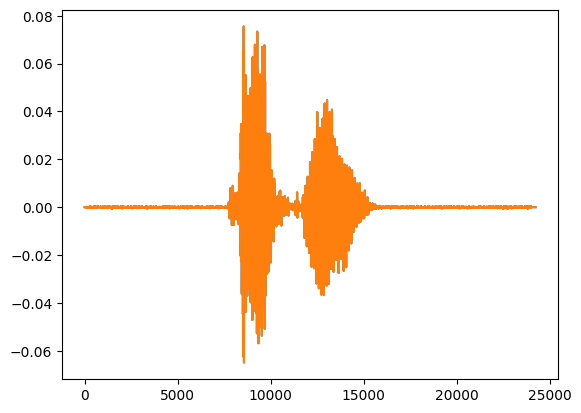

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
print("Label of waveform: {}".format(label))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “backward”.




In [ ]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

In [ ]:
waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “zero”.







In [ ]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

## Formatting the Data

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 10

if device == "cuda":
    num_workers = 256
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the Network

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(2, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=18, gamma=0.1)  # reduce the learning after 18 epochs by a factor of 10

## Training and Testing the Network

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data.contiguous()) # Ensure data is contiguous before applying transform
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [ ]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        data = transform(data.contiguous())
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




In [ ]:
log_interval = 5
n_epoch = 22

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|          | 0.028985507246376812/20 [00:00<02:24,  7.24s/it]

Train Epoch: 1 [0/535 (0%)]	Loss: 3.744446


  1%|          | 0.11594202898550723/20 [00:00<02:15,  6.82s/it]

Train Epoch: 1 [50/535 (9%)]	Loss: 3.252906


  1%|          | 0.1739130434782609/20 [00:01<02:17,  6.91s/it] 

Train Epoch: 1 [100/535 (19%)]	Loss: 3.254390


  1%|▏         | 0.26086956521739135/20 [00:01<02:10,  6.63s/it]

Train Epoch: 1 [150/535 (28%)]	Loss: 3.637258


  2%|▏         | 0.318840579710145/20 [00:02<02:07,  6.46s/it] 

Train Epoch: 1 [200/535 (37%)]	Loss: 3.477170


  2%|▏         | 0.4057971014492755/20 [00:02<02:11,  6.71s/it] 

Train Epoch: 1 [250/535 (46%)]	Loss: 3.174408


  2%|▏         | 0.46376811594202916/20 [00:03<02:09,  6.62s/it]

Train Epoch: 1 [300/535 (56%)]	Loss: 3.600039


  3%|▎         | 0.5217391304347827/20 [00:03<02:03,  6.34s/it]

Train Epoch: 1 [350/535 (65%)]	Loss: 2.957685


  3%|▎         | 0.6086956521739129/20 [00:04<02:04,  6.42s/it]

Train Epoch: 1 [400/535 (74%)]	Loss: 3.201174


  3%|▎         | 0.6811594202898547/20 [00:04<02:42,  8.39s/it]

Train Epoch: 1 [450/535 (83%)]	Loss: 3.261173


  4%|▍         | 0.7536231884057965/20 [00:05<03:02,  9.48s/it]

Train Epoch: 1 [500/535 (93%)]	Loss: 3.059032


  5%|▌         | 1.0289855072463754/20 [00:07<02:08,  6.77s/it]


Test Epoch: 1	Accuracy: 6/145 (4%)

Train Epoch: 2 [0/535 (0%)]	Loss: 3.222335


  6%|▌         | 1.1159420289855062/20 [00:08<02:03,  6.54s/it]

Train Epoch: 2 [50/535 (9%)]	Loss: 3.050375


  6%|▌         | 1.17391304347826/20 [00:08<02:02,  6.52s/it]  

Train Epoch: 2 [100/535 (19%)]	Loss: 2.944656


  6%|▋         | 1.260869565217391/20 [00:09<02:05,  6.71s/it]

Train Epoch: 2 [150/535 (28%)]	Loss: 3.452490


  7%|▋         | 1.3188405797101448/20 [00:09<02:02,  6.57s/it]

Train Epoch: 2 [200/535 (37%)]	Loss: 3.553757


  7%|▋         | 1.4057971014492756/20 [00:10<02:02,  6.57s/it]

Train Epoch: 2 [250/535 (46%)]	Loss: 2.811478


  7%|▋         | 1.4637681159420295/20 [00:10<02:03,  6.69s/it]

Train Epoch: 2 [300/535 (56%)]	Loss: 2.804537


  8%|▊         | 1.5507246376811603/20 [00:11<02:01,  6.57s/it]

Train Epoch: 2 [350/535 (65%)]	Loss: 2.898923


  8%|▊         | 1.6086956521739142/20 [00:11<01:58,  6.43s/it]

Train Epoch: 2 [400/535 (74%)]	Loss: 2.729347


  8%|▊         | 1.666666666666668/20 [00:11<01:59,  6.54s/it] 

Train Epoch: 2 [450/535 (83%)]	Loss: 2.945906


  9%|▉         | 1.753623188405799/20 [00:12<02:03,  6.74s/it]

Train Epoch: 2 [500/535 (93%)]	Loss: 2.572831


 10%|█         | 2.014492753623191/20 [00:13<01:39,  5.56s/it] 


Test Epoch: 2	Accuracy: 11/145 (8%)

Train Epoch: 3 [0/535 (0%)]	Loss: 2.878135


 11%|█         | 2.101449275362322/20 [00:14<01:49,  6.12s/it]

Train Epoch: 3 [50/535 (9%)]	Loss: 3.071863


 11%|█         | 2.159420289855076/20 [00:14<01:53,  6.38s/it]

Train Epoch: 3 [100/535 (19%)]	Loss: 2.660377


 11%|█         | 2.2463768115942067/20 [00:15<01:53,  6.39s/it]

Train Epoch: 3 [150/535 (28%)]	Loss: 3.015252


 12%|█▏        | 2.3333333333333375/20 [00:15<01:55,  6.51s/it]

Train Epoch: 3 [200/535 (37%)]	Loss: 2.157902


 12%|█▏        | 2.3913043478260914/20 [00:16<01:56,  6.63s/it]

Train Epoch: 3 [250/535 (46%)]	Loss: 2.235585


 12%|█▏        | 2.478260869565222/20 [00:16<01:55,  6.58s/it] 

Train Epoch: 3 [300/535 (56%)]	Loss: 3.053301


 13%|█▎        | 2.536231884057976/20 [00:17<02:10,  7.50s/it]

Train Epoch: 3 [350/535 (65%)]	Loss: 2.840641


 13%|█▎        | 2.6086956521739184/20 [00:18<02:43,  9.42s/it]

Train Epoch: 3 [400/535 (74%)]	Loss: 2.712877


 13%|█▎        | 2.6811594202898608/20 [00:18<02:53,  9.99s/it]

Train Epoch: 3 [450/535 (83%)]	Loss: 1.951986


 14%|█▍        | 2.753623188405803/20 [00:19<02:55, 10.18s/it] 

Train Epoch: 3 [500/535 (93%)]	Loss: 2.101106


 15%|█▌        | 3.0144927536231956/20 [00:21<01:38,  5.77s/it]


Test Epoch: 3	Accuracy: 28/145 (19%)

Train Epoch: 4 [0/535 (0%)]	Loss: 1.884563


 16%|█▌        | 3.1014492753623264/20 [00:21<01:45,  6.27s/it]

Train Epoch: 4 [50/535 (9%)]	Loss: 1.847163


 16%|█▌        | 3.188405797101457/20 [00:22<01:47,  6.38s/it] 

Train Epoch: 4 [100/535 (19%)]	Loss: 2.476666


 16%|█▌        | 3.246376811594211/20 [00:22<01:47,  6.39s/it]

Train Epoch: 4 [150/535 (28%)]	Loss: 2.232922


 17%|█▋        | 3.333333333333342/20 [00:23<01:47,  6.45s/it]

Train Epoch: 4 [200/535 (37%)]	Loss: 1.584768


 17%|█▋        | 3.391304347826096/20 [00:23<01:52,  6.76s/it]

Train Epoch: 4 [250/535 (46%)]	Loss: 1.901394


 17%|█▋        | 3.4782608695652266/20 [00:24<01:50,  6.68s/it]

Train Epoch: 4 [300/535 (56%)]	Loss: 1.990800


 18%|█▊        | 3.5362318840579805/20 [00:24<01:55,  7.04s/it]

Train Epoch: 4 [350/535 (65%)]	Loss: 2.056702


 18%|█▊        | 3.6231884057971113/20 [00:25<01:44,  6.40s/it]

Train Epoch: 4 [400/535 (74%)]	Loss: 2.259852


 18%|█▊        | 3.681159420289865/20 [00:25<01:44,  6.39s/it] 

Train Epoch: 4 [450/535 (83%)]	Loss: 2.099720


 19%|█▉        | 3.768115942028996/20 [00:26<01:45,  6.51s/it]

Train Epoch: 4 [500/535 (93%)]	Loss: 1.676683


 20%|██        | 4.0289855072463885/20 [00:27<01:33,  5.85s/it]


Test Epoch: 4	Accuracy: 50/145 (34%)

Train Epoch: 5 [0/535 (0%)]	Loss: 1.491604


 21%|██        | 4.115942028985519/20 [00:28<01:37,  6.12s/it]

Train Epoch: 5 [50/535 (9%)]	Loss: 1.696999


 21%|██        | 4.173913043478273/20 [00:28<01:39,  6.32s/it]

Train Epoch: 5 [100/535 (19%)]	Loss: 1.478735


 21%|██▏       | 4.260869565217404/20 [00:29<01:42,  6.53s/it]

Train Epoch: 5 [150/535 (28%)]	Loss: 2.576892


 22%|██▏       | 4.318840579710158/20 [00:29<01:42,  6.56s/it]

Train Epoch: 5 [200/535 (37%)]	Loss: 2.131553


 22%|██▏       | 4.376811594202912/20 [00:29<01:43,  6.65s/it]

Train Epoch: 5 [250/535 (46%)]	Loss: 2.119430


 22%|██▏       | 4.463768115942043/20 [00:30<02:23,  9.21s/it]

Train Epoch: 5 [300/535 (56%)]	Loss: 1.830877


 23%|██▎       | 4.536231884057985/20 [00:31<02:29,  9.64s/it] 

Train Epoch: 5 [350/535 (65%)]	Loss: 1.611157


 23%|██▎       | 4.608695652173927/20 [00:32<02:33,  9.98s/it]

Train Epoch: 5 [400/535 (74%)]	Loss: 1.212738


 23%|██▎       | 4.695652173913058/20 [00:32<02:11,  8.60s/it]

Train Epoch: 5 [450/535 (83%)]	Loss: 1.543499


 24%|██▍       | 4.753623188405812/20 [00:33<01:51,  7.30s/it]

Train Epoch: 5 [500/535 (93%)]	Loss: 0.934598


 25%|██▌       | 5.028985507246393/20 [00:35<01:29,  6.01s/it]


Test Epoch: 5	Accuracy: 58/145 (40%)

Train Epoch: 6 [0/535 (0%)]	Loss: 2.470281


 26%|██▌       | 5.115942028985524/20 [00:35<01:33,  6.25s/it]

Train Epoch: 6 [50/535 (9%)]	Loss: 1.098562


 26%|██▌       | 5.173913043478278/20 [00:36<01:33,  6.31s/it]

Train Epoch: 6 [100/535 (19%)]	Loss: 0.965927


 26%|██▋       | 5.2608695652174085/20 [00:36<01:34,  6.43s/it]

Train Epoch: 6 [150/535 (28%)]	Loss: 1.747259


 27%|██▋       | 5.318840579710162/20 [00:37<01:36,  6.56s/it]

Train Epoch: 6 [200/535 (37%)]	Loss: 1.940338


 27%|██▋       | 5.405797101449293/20 [00:37<01:35,  6.52s/it]

Train Epoch: 6 [250/535 (46%)]	Loss: 0.761214


 27%|██▋       | 5.463768115942047/20 [00:38<01:34,  6.47s/it]

Train Epoch: 6 [300/535 (56%)]	Loss: 1.114476


 28%|██▊       | 5.550724637681178/20 [00:38<01:34,  6.56s/it]

Train Epoch: 6 [350/535 (65%)]	Loss: 1.448951


 28%|██▊       | 5.608695652173932/20 [00:39<01:33,  6.48s/it]

Train Epoch: 6 [400/535 (74%)]	Loss: 0.719121


 28%|██▊       | 5.6956521739130626/20 [00:39<01:32,  6.50s/it]

Train Epoch: 6 [450/535 (83%)]	Loss: 1.299293


 29%|██▉       | 5.753623188405816/20 [00:40<01:33,  6.53s/it] 

Train Epoch: 6 [500/535 (93%)]	Loss: 0.815202


 30%|███       | 6.014492753623209/20 [00:41<01:17,  5.57s/it]


Test Epoch: 6	Accuracy: 28/145 (19%)

Train Epoch: 7 [0/535 (0%)]	Loss: 1.142663


 31%|███       | 6.10144927536234/20 [00:42<01:27,  6.27s/it] 

Train Epoch: 7 [50/535 (9%)]	Loss: 0.654570


 31%|███       | 6.1884057971014705/20 [00:42<01:28,  6.42s/it]

Train Epoch: 7 [100/535 (19%)]	Loss: 1.020583


 31%|███       | 6.246376811594224/20 [00:43<01:46,  7.74s/it] 

Train Epoch: 7 [150/535 (28%)]	Loss: 1.517665


 32%|███▏      | 6.318840579710167/20 [00:43<02:07,  9.28s/it]

Train Epoch: 7 [200/535 (37%)]	Loss: 1.123425


 32%|███▏      | 6.391304347826109/20 [00:44<02:13,  9.83s/it]

Train Epoch: 7 [250/535 (46%)]	Loss: 0.637643


 32%|███▏      | 6.4637681159420515/20 [00:45<02:16, 10.11s/it]

Train Epoch: 7 [300/535 (56%)]	Loss: 1.322234


 33%|███▎      | 6.550724637681182/20 [00:46<01:42,  7.59s/it]

Train Epoch: 7 [350/535 (65%)]	Loss: 1.121357


 33%|███▎      | 6.623188405797125/20 [00:46<01:33,  6.96s/it]

Train Epoch: 7 [400/535 (74%)]	Loss: 0.454157


 33%|███▎      | 6.695652173913067/20 [00:47<01:30,  6.83s/it]

Train Epoch: 7 [450/535 (83%)]	Loss: 1.129332


 34%|███▍      | 6.768115942029009/20 [00:47<01:27,  6.61s/it]

Train Epoch: 7 [500/535 (93%)]	Loss: 0.950994


 35%|███▌      | 7.028985507246402/20 [00:48<01:15,  5.80s/it]


Test Epoch: 7	Accuracy: 85/145 (59%)

Train Epoch: 8 [0/535 (0%)]	Loss: 0.968329


 36%|███▌      | 7.115942028985533/20 [00:49<01:19,  6.20s/it]

Train Epoch: 8 [50/535 (9%)]	Loss: 0.792284


 36%|███▌      | 7.1739130434782865/20 [00:49<01:20,  6.25s/it]

Train Epoch: 8 [100/535 (19%)]	Loss: 0.540281


 36%|███▋      | 7.260869565217417/20 [00:50<01:21,  6.39s/it]

Train Epoch: 8 [150/535 (28%)]	Loss: 0.423521


 36%|███▋      | 7.289855072463794/20 [00:50<01:23,  6.53s/it]

Train Epoch: 8 [200/535 (37%)]	Loss: 1.133440


 37%|███▋      | 7.405797101449302/20 [00:51<01:40,  8.01s/it]

Train Epoch: 8 [250/535 (46%)]	Loss: 1.648988


 37%|███▋      | 7.463768115942056/20 [00:52<02:06, 10.07s/it]

Train Epoch: 8 [300/535 (56%)]	Loss: 1.242133


 38%|███▊      | 7.550724637681187/20 [00:53<01:31,  7.37s/it]

Train Epoch: 8 [350/535 (65%)]	Loss: 0.258163


 38%|███▊      | 7.623188405797129/20 [00:53<01:26,  7.01s/it]

Train Epoch: 8 [400/535 (74%)]	Loss: 1.281960


 38%|███▊      | 7.695652173913071/20 [00:54<01:20,  6.57s/it] 

Train Epoch: 8 [450/535 (83%)]	Loss: 0.866538


 39%|███▉      | 7.753623188405825/20 [00:54<01:20,  6.57s/it]

Train Epoch: 8 [500/535 (93%)]	Loss: 0.715560


 40%|████      | 8.014492753623216/20 [00:56<01:25,  7.11s/it]


Test Epoch: 8	Accuracy: 82/145 (57%)

Train Epoch: 9 [0/535 (0%)]	Loss: 0.836820


 41%|████      | 8.101449275362341/20 [00:57<01:47,  9.03s/it]

Train Epoch: 9 [50/535 (9%)]	Loss: 0.976878


 41%|████      | 8.17391304347828/20 [00:57<01:54,  9.64s/it] 

Train Epoch: 9 [100/535 (19%)]	Loss: 0.343816


 41%|████      | 8.246376811594217/20 [00:58<01:46,  9.09s/it]

Train Epoch: 9 [150/535 (28%)]	Loss: 0.255833


 42%|████▏     | 8.333333333333343/20 [00:58<01:19,  6.84s/it]

Train Epoch: 9 [200/535 (37%)]	Loss: 0.495346


 42%|████▏     | 8.391304347826093/20 [00:59<01:16,  6.55s/it]

Train Epoch: 9 [250/535 (46%)]	Loss: 0.781775


 42%|████▏     | 8.478260869565219/20 [00:59<01:16,  6.60s/it]

Train Epoch: 9 [300/535 (56%)]	Loss: 0.539379


 43%|████▎     | 8.536231884057969/20 [01:00<01:14,  6.50s/it]

Train Epoch: 9 [350/535 (65%)]	Loss: 0.259394


 43%|████▎     | 8.623188405797094/20 [01:00<01:13,  6.49s/it]

Train Epoch: 9 [400/535 (74%)]	Loss: 1.070181


 43%|████▎     | 8.681159420289845/20 [01:01<01:14,  6.58s/it]

Train Epoch: 9 [450/535 (83%)]	Loss: 0.222195


 44%|████▍     | 8.76811594202897/20 [01:01<01:15,  6.75s/it] 

Train Epoch: 9 [500/535 (93%)]	Loss: 0.942789


 45%|████▌     | 9.028985507246347/20 [01:03<01:06,  6.11s/it]


Test Epoch: 9	Accuracy: 101/145 (70%)

Train Epoch: 10 [0/535 (0%)]	Loss: 1.057684


 46%|████▌     | 9.115942028985472/20 [01:03<01:11,  6.55s/it]

Train Epoch: 10 [50/535 (9%)]	Loss: 0.315070


 46%|████▌     | 9.173913043478223/20 [01:04<01:11,  6.57s/it]

Train Epoch: 10 [100/535 (19%)]	Loss: 0.855129


 46%|████▋     | 9.260869565217348/20 [01:04<01:11,  6.69s/it]

Train Epoch: 10 [150/535 (28%)]	Loss: 1.449341


 47%|████▋     | 9.318840579710098/20 [01:05<01:10,  6.59s/it]

Train Epoch: 10 [200/535 (37%)]	Loss: 0.230669


 47%|████▋     | 9.405797101449224/20 [01:05<01:11,  6.70s/it]

Train Epoch: 10 [250/535 (46%)]	Loss: 0.837837


 47%|████▋     | 9.463768115941974/20 [01:06<01:09,  6.60s/it]

Train Epoch: 10 [300/535 (56%)]	Loss: 0.401211


 48%|████▊     | 9.5507246376811/20 [01:06<01:08,  6.56s/it]  

Train Epoch: 10 [350/535 (65%)]	Loss: 0.290386


 48%|████▊     | 9.60869565217385/20 [01:07<01:07,  6.46s/it] 

Train Epoch: 10 [400/535 (74%)]	Loss: 0.249830


 48%|████▊     | 9.695652173912976/20 [01:07<01:08,  6.68s/it]

Train Epoch: 10 [450/535 (83%)]	Loss: 0.598671


 49%|████▉     | 9.753623188405726/20 [01:08<01:07,  6.62s/it]

Train Epoch: 10 [500/535 (93%)]	Loss: 0.454126


 50%|█████     | 10.014492753623102/20 [01:10<01:22,  8.25s/it]


Test Epoch: 10	Accuracy: 121/145 (83%)

Train Epoch: 11 [0/535 (0%)]	Loss: 0.229961


 51%|█████     | 10.101449275362228/20 [01:11<01:25,  8.68s/it]

Train Epoch: 11 [50/535 (9%)]	Loss: 0.409082


 51%|█████     | 10.188405797101353/20 [01:11<01:09,  7.03s/it]

Train Epoch: 11 [100/535 (19%)]	Loss: 0.078870


 51%|█████     | 10.246376811594104/20 [01:12<01:05,  6.74s/it]

Train Epoch: 11 [150/535 (28%)]	Loss: 0.576445


 52%|█████▏    | 10.33333333333323/20 [01:12<01:04,  6.68s/it] 

Train Epoch: 11 [200/535 (37%)]	Loss: 0.261242


 52%|█████▏    | 10.39130434782598/20 [01:13<01:02,  6.55s/it] 

Train Epoch: 11 [250/535 (46%)]	Loss: 0.666701


 52%|█████▏    | 10.44927536231873/20 [01:13<01:01,  6.47s/it] 

Train Epoch: 11 [300/535 (56%)]	Loss: 0.711967


 53%|█████▎    | 10.536231884057855/20 [01:14<01:03,  6.75s/it]

Train Epoch: 11 [350/535 (65%)]	Loss: 0.144554


 53%|█████▎    | 10.62318840579698/20 [01:14<01:03,  6.79s/it] 

Train Epoch: 11 [400/535 (74%)]	Loss: 0.492788


 53%|█████▎    | 10.681159420289731/20 [01:15<01:03,  6.82s/it]

Train Epoch: 11 [450/535 (83%)]	Loss: 0.773316


 54%|█████▎    | 10.739130434782481/20 [01:15<01:02,  6.74s/it]

Train Epoch: 11 [500/535 (93%)]	Loss: 0.491280


 55%|█████▌    | 11.028985507246233/20 [01:17<00:53,  5.95s/it]


Test Epoch: 11	Accuracy: 120/145 (83%)

Train Epoch: 12 [0/535 (0%)]	Loss: 0.120733


 56%|█████▌    | 11.115942028985359/20 [01:17<00:57,  6.43s/it]

Train Epoch: 12 [50/535 (9%)]	Loss: 0.041427


 56%|█████▌    | 11.173913043478109/20 [01:18<00:58,  6.60s/it]

Train Epoch: 12 [100/535 (19%)]	Loss: 0.398745


 56%|█████▋    | 11.260869565217234/20 [01:18<00:58,  6.69s/it]

Train Epoch: 12 [150/535 (28%)]	Loss: 0.639562


 57%|█████▋    | 11.318840579709985/20 [01:19<00:58,  6.74s/it]

Train Epoch: 12 [200/535 (37%)]	Loss: 0.321788


 57%|█████▋    | 11.376811594202735/20 [01:19<00:57,  6.66s/it]

Train Epoch: 12 [250/535 (46%)]	Loss: 0.284164


 57%|█████▋    | 11.46376811594186/20 [01:20<00:56,  6.61s/it] 

Train Epoch: 12 [300/535 (56%)]	Loss: 0.051954


 58%|█████▊    | 11.52173913043461/20 [01:20<00:55,  6.60s/it] 

Train Epoch: 12 [350/535 (65%)]	Loss: 0.261234


 58%|█████▊    | 11.608695652173736/20 [01:21<01:01,  7.32s/it]

Train Epoch: 12 [400/535 (74%)]	Loss: 0.406461


 58%|█████▊    | 11.681159420289674/20 [01:21<01:15,  9.07s/it]

Train Epoch: 12 [450/535 (83%)]	Loss: 0.045770


 59%|█████▉    | 11.753623188405612/20 [01:22<01:17,  9.44s/it]

Train Epoch: 12 [500/535 (93%)]	Loss: 0.399873


 60%|██████    | 12.014492753622989/20 [01:24<00:48,  6.09s/it]


Test Epoch: 12	Accuracy: 121/145 (83%)

Train Epoch: 13 [0/535 (0%)]	Loss: 0.284601


 61%|██████    | 12.101449275362114/20 [01:25<00:51,  6.47s/it]

Train Epoch: 13 [50/535 (9%)]	Loss: 0.157371


 61%|██████    | 12.18840579710124/20 [01:25<00:50,  6.52s/it] 

Train Epoch: 13 [100/535 (19%)]	Loss: 0.559194


 61%|██████    | 12.24637681159399/20 [01:26<00:51,  6.64s/it] 

Train Epoch: 13 [150/535 (28%)]	Loss: 0.108629


 62%|██████▏   | 12.333333333333115/20 [01:26<00:51,  6.74s/it]

Train Epoch: 13 [200/535 (37%)]	Loss: 0.371425


 62%|██████▏   | 12.391304347825866/20 [01:27<00:51,  6.72s/it]

Train Epoch: 13 [250/535 (46%)]	Loss: 0.156847


 62%|██████▏   | 12.478260869564991/20 [01:27<00:49,  6.64s/it]

Train Epoch: 13 [300/535 (56%)]	Loss: 0.078327


 63%|██████▎   | 12.536231884057742/20 [01:27<00:49,  6.60s/it]

Train Epoch: 13 [350/535 (65%)]	Loss: 0.353109


 63%|██████▎   | 12.623188405796867/20 [01:28<00:48,  6.56s/it]

Train Epoch: 13 [400/535 (74%)]	Loss: 0.248487


 63%|██████▎   | 12.681159420289617/20 [01:28<00:48,  6.66s/it]

Train Epoch: 13 [450/535 (83%)]	Loss: 0.035537


 64%|██████▍   | 12.768115942028743/20 [01:29<00:48,  6.74s/it]

Train Epoch: 13 [500/535 (93%)]	Loss: 0.451562


 65%|██████▌   | 13.02898550724612/20 [01:31<00:40,  5.87s/it] 


Test Epoch: 13	Accuracy: 114/145 (79%)

Train Epoch: 14 [0/535 (0%)]	Loss: 0.162405


 66%|██████▌   | 13.115942028985245/20 [01:31<00:45,  6.58s/it]

Train Epoch: 14 [50/535 (9%)]	Loss: 0.127190


 66%|██████▌   | 13.173913043477995/20 [01:32<00:46,  6.77s/it]

Train Epoch: 14 [100/535 (19%)]	Loss: 0.378995


 66%|██████▌   | 13.231884057970746/20 [01:32<00:46,  6.80s/it]

Train Epoch: 14 [150/535 (28%)]	Loss: 0.136404


 67%|██████▋   | 13.318840579709871/20 [01:33<00:46,  6.94s/it]

Train Epoch: 14 [200/535 (37%)]	Loss: 0.274552


 67%|██████▋   | 13.376811594202621/20 [01:33<00:44,  6.65s/it]

Train Epoch: 14 [250/535 (46%)]	Loss: 0.065460


 67%|██████▋   | 13.463768115941747/20 [01:34<00:47,  7.29s/it]

Train Epoch: 14 [300/535 (56%)]	Loss: 0.041885


 68%|██████▊   | 13.536231884057685/20 [01:34<00:59,  9.17s/it]

Train Epoch: 14 [350/535 (65%)]	Loss: 0.355515


 68%|██████▊   | 13.608695652173623/20 [01:35<01:02,  9.81s/it]

Train Epoch: 14 [400/535 (74%)]	Loss: 0.011685


 68%|██████▊   | 13.68115942028956/20 [01:36<01:04, 10.26s/it] 

Train Epoch: 14 [450/535 (83%)]	Loss: 0.082144


 69%|██████▉   | 13.768115942028686/20 [01:37<00:49,  8.02s/it]

Train Epoch: 14 [500/535 (93%)]	Loss: 0.122729


 70%|███████   | 14.028985507246063/20 [01:38<00:35,  5.88s/it]


Test Epoch: 14	Accuracy: 125/145 (86%)

Train Epoch: 15 [0/535 (0%)]	Loss: 0.105872


 71%|███████   | 14.115942028985188/20 [01:39<00:39,  6.63s/it]

Train Epoch: 15 [50/535 (9%)]	Loss: 0.203905


 71%|███████   | 14.173913043477938/20 [01:39<00:39,  6.71s/it]

Train Epoch: 15 [100/535 (19%)]	Loss: 0.129335


 71%|███████▏  | 14.260869565217064/20 [01:40<00:38,  6.75s/it]

Train Epoch: 15 [150/535 (28%)]	Loss: 0.088607


 72%|███████▏  | 14.318840579709814/20 [01:40<00:38,  6.85s/it]

Train Epoch: 15 [200/535 (37%)]	Loss: 0.216391


 72%|███████▏  | 14.40579710144894/20 [01:41<00:37,  6.75s/it] 

Train Epoch: 15 [250/535 (46%)]	Loss: 0.161397


 72%|███████▏  | 14.46376811594169/20 [01:41<00:36,  6.68s/it] 

Train Epoch: 15 [300/535 (56%)]	Loss: 0.067045


 73%|███████▎  | 14.550724637680815/20 [01:42<00:35,  6.55s/it]

Train Epoch: 15 [350/535 (65%)]	Loss: 0.212080


 73%|███████▎  | 14.608695652173566/20 [01:42<00:34,  6.46s/it]

Train Epoch: 15 [400/535 (74%)]	Loss: 0.040832


 73%|███████▎  | 14.695652173912691/20 [01:42<00:34,  6.53s/it]

Train Epoch: 15 [450/535 (83%)]	Loss: 0.112770


 74%|███████▍  | 14.753623188405442/20 [01:43<00:33,  6.42s/it]

Train Epoch: 15 [500/535 (93%)]	Loss: 0.208335


 75%|███████▌  | 15.014492753622818/20 [01:44<00:27,  5.49s/it]


Test Epoch: 15	Accuracy: 127/145 (88%)

Train Epoch: 16 [0/535 (0%)]	Loss: 0.084985


 76%|███████▌  | 15.101449275361944/20 [01:45<00:29,  6.12s/it]

Train Epoch: 16 [50/535 (9%)]	Loss: 0.717298


 76%|███████▌  | 15.188405797101069/20 [01:45<00:31,  6.52s/it]

Train Epoch: 16 [100/535 (19%)]	Loss: 0.263933


 76%|███████▌  | 15.24637681159382/20 [01:46<00:30,  6.44s/it] 

Train Epoch: 16 [150/535 (28%)]	Loss: 0.116663


 77%|███████▋  | 15.30434782608657/20 [01:46<00:30,  6.46s/it] 

Train Epoch: 16 [200/535 (37%)]	Loss: 0.352285


 77%|███████▋  | 15.391304347825695/20 [01:47<00:42,  9.14s/it]

Train Epoch: 16 [250/535 (46%)]	Loss: 0.557756


 77%|███████▋  | 15.463768115941633/20 [01:48<00:43,  9.68s/it]

Train Epoch: 16 [300/535 (56%)]	Loss: 0.327849


 78%|███████▊  | 15.536231884057571/20 [01:48<00:43,  9.66s/it]

Train Epoch: 16 [350/535 (65%)]	Loss: 0.231838


 78%|███████▊  | 15.608695652173509/20 [01:49<00:45, 10.29s/it]

Train Epoch: 16 [400/535 (74%)]	Loss: 0.112752


 78%|███████▊  | 15.695652173912634/20 [01:50<00:31,  7.41s/it]

Train Epoch: 16 [450/535 (83%)]	Loss: 0.106528


 79%|███████▉  | 15.753623188405385/20 [01:50<00:29,  6.91s/it]

Train Epoch: 16 [500/535 (93%)]	Loss: 0.229857


 80%|████████  | 16.01449275362276/20 [01:52<00:23,  5.93s/it] 


Test Epoch: 16	Accuracy: 129/145 (89%)

Train Epoch: 17 [0/535 (0%)]	Loss: 0.143010


 81%|████████  | 16.101449275361887/20 [01:52<00:24,  6.36s/it]

Train Epoch: 17 [50/535 (9%)]	Loss: 0.109483


 81%|████████  | 16.159420289854637/20 [01:53<00:25,  6.64s/it]

Train Epoch: 17 [100/535 (19%)]	Loss: 0.080824


 81%|████████  | 16.246376811593763/20 [01:53<00:25,  6.79s/it]

Train Epoch: 17 [150/535 (28%)]	Loss: 0.105449


 82%|████████▏ | 16.304347826086513/20 [01:54<00:24,  6.58s/it]

Train Epoch: 17 [200/535 (37%)]	Loss: 0.212656


 82%|████████▏ | 16.39130434782564/20 [01:54<00:24,  6.70s/it] 

Train Epoch: 17 [250/535 (46%)]	Loss: 0.077040


 82%|████████▏ | 16.478260869564764/20 [01:55<00:23,  6.62s/it]

Train Epoch: 17 [300/535 (56%)]	Loss: 0.037885


 83%|████████▎ | 16.536231884057514/20 [01:55<00:22,  6.52s/it]

Train Epoch: 17 [350/535 (65%)]	Loss: 0.004207


 83%|████████▎ | 16.594202898550265/20 [01:56<00:22,  6.63s/it]

Train Epoch: 17 [400/535 (74%)]	Loss: 0.438895


 83%|████████▎ | 16.695652173912578/20 [01:56<00:22,  6.86s/it]

Train Epoch: 17 [450/535 (83%)]	Loss: 0.862818


 84%|████████▍ | 16.753623188405328/20 [01:57<00:21,  6.57s/it]

Train Epoch: 17 [500/535 (93%)]	Loss: 0.032719


 85%|████████▌ | 17.014492753622704/20 [01:58<00:17,  5.81s/it]


Test Epoch: 17	Accuracy: 102/145 (70%)

Train Epoch: 18 [0/535 (0%)]	Loss: 0.369457


 86%|████████▌ | 17.10144927536183/20 [01:59<00:18,  6.39s/it] 

Train Epoch: 18 [50/535 (9%)]	Loss: 0.350760


 86%|████████▌ | 17.15942028985458/20 [01:59<00:18,  6.59s/it] 

Train Epoch: 18 [100/535 (19%)]	Loss: 0.209826


 86%|████████▌ | 17.246376811593706/20 [02:00<00:23,  8.59s/it]

Train Epoch: 18 [150/535 (28%)]	Loss: 0.096709


 87%|████████▋ | 17.318840579709644/20 [02:01<00:26,  9.95s/it]

Train Epoch: 18 [200/535 (37%)]	Loss: 0.120275


 87%|████████▋ | 17.39130434782558/20 [02:01<00:26,  9.97s/it] 

Train Epoch: 18 [250/535 (46%)]	Loss: 0.496151


 87%|████████▋ | 17.478260869564707/20 [02:02<00:20,  8.27s/it]

Train Epoch: 18 [300/535 (56%)]	Loss: 0.180481


 88%|████████▊ | 17.550724637680645/20 [02:03<00:17,  7.00s/it]

Train Epoch: 18 [350/535 (65%)]	Loss: 1.561580


 88%|████████▊ | 17.594202898550208/20 [02:03<00:16,  6.72s/it]

Train Epoch: 18 [400/535 (74%)]	Loss: 0.058509


 88%|████████▊ | 17.681159420289333/20 [02:04<00:15,  6.63s/it]

Train Epoch: 18 [450/535 (83%)]	Loss: 0.732538


 89%|████████▉ | 17.76811594202846/20 [02:04<00:14,  6.61s/it] 

Train Epoch: 18 [500/535 (93%)]	Loss: 0.167430


 90%|█████████ | 18.028985507245835/20 [02:06<00:11,  5.81s/it]


Test Epoch: 18	Accuracy: 107/145 (74%)

Train Epoch: 19 [0/535 (0%)]	Loss: 0.788879


 90%|█████████ | 18.086956521738585/20 [02:06<00:11,  6.08s/it]

Train Epoch: 19 [50/535 (9%)]	Loss: 0.227231


 91%|█████████ | 18.17391304347771/20 [02:07<00:12,  6.74s/it] 

Train Epoch: 19 [100/535 (19%)]	Loss: 0.335757


 91%|█████████ | 18.23188405797046/20 [02:07<00:11,  6.59s/it] 

Train Epoch: 19 [150/535 (28%)]	Loss: 1.171239


 92%|█████████▏| 18.318840579709587/20 [02:08<00:11,  6.71s/it]

Train Epoch: 19 [200/535 (37%)]	Loss: 0.302377


 92%|█████████▏| 18.405797101448712/20 [02:08<00:10,  6.45s/it]

Train Epoch: 19 [250/535 (46%)]	Loss: 0.660352


 92%|█████████▏| 18.463768115941463/20 [02:08<00:10,  6.69s/it]

Train Epoch: 19 [300/535 (56%)]	Loss: 1.589440


 93%|█████████▎| 18.550724637680588/20 [02:09<00:09,  6.73s/it]

Train Epoch: 19 [350/535 (65%)]	Loss: 0.170642


 93%|█████████▎| 18.60869565217334/20 [02:09<00:09,  6.76s/it] 

Train Epoch: 19 [400/535 (74%)]	Loss: 0.749424


 93%|█████████▎| 18.695652173912464/20 [02:10<00:08,  6.59s/it]

Train Epoch: 19 [450/535 (83%)]	Loss: 0.483445


 94%|█████████▍| 18.753623188405214/20 [02:10<00:08,  6.58s/it]

Train Epoch: 19 [500/535 (93%)]	Loss: 0.210473


 95%|█████████▌| 19.01449275362259/20 [02:12<00:05,  5.68s/it] 


Test Epoch: 19	Accuracy: 127/145 (88%)

Train Epoch: 20 [0/535 (0%)]	Loss: 0.112504


 96%|█████████▌| 19.101449275361716/20 [02:13<00:07,  8.34s/it]

Train Epoch: 20 [50/535 (9%)]	Loss: 0.042751


 96%|█████████▌| 19.173913043477654/20 [02:13<00:08,  9.81s/it]

Train Epoch: 20 [100/535 (19%)]	Loss: 0.022912


 96%|█████████▌| 19.246376811593592/20 [02:14<00:07,  9.98s/it]

Train Epoch: 20 [150/535 (28%)]	Loss: 0.015419


 97%|█████████▋| 19.333333333332718/20 [02:15<00:05,  8.28s/it]

Train Epoch: 20 [200/535 (37%)]	Loss: 0.054781


 97%|█████████▋| 19.391304347825468/20 [02:15<00:04,  7.31s/it]

Train Epoch: 20 [250/535 (46%)]	Loss: 0.177528


 97%|█████████▋| 19.463768115941406/20 [02:16<00:03,  6.73s/it]

Train Epoch: 20 [300/535 (56%)]	Loss: 0.066119


 98%|█████████▊| 19.55072463768053/20 [02:16<00:02,  6.58s/it] 

Train Epoch: 20 [350/535 (65%)]	Loss: 0.017845


 98%|█████████▊| 19.60869565217328/20 [02:17<00:02,  6.72s/it] 

Train Epoch: 20 [400/535 (74%)]	Loss: 0.148780


 98%|█████████▊| 19.695652173912407/20 [02:17<00:01,  6.51s/it]

Train Epoch: 20 [450/535 (83%)]	Loss: 0.008803


 99%|█████████▉| 19.753623188405157/20 [02:18<00:01,  6.78s/it]

Train Epoch: 20 [500/535 (93%)]	Loss: 0.015453


100%|█████████▉| 19.999999999999346/20 [02:19<00:00,  6.98s/it]


Test Epoch: 20	Accuracy: 134/145 (92%)



The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    # The input tensor needs to have 2 channels
    tensor = tensor.unsqueeze(0) # add an extra dimension for the batch
    tensor = model(tensor)
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-20]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


Let’s find an example that isn’t classified correctly, if there is one.




In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #8. Expected: bird. Predicted: learn.


In [ ]:
def record(seconds=1):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

Recording started for 1 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Predicted: no.
